## Installations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import load_model
from imutils import paths
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os

## Helper Variables & Functions

In [ ]:
ORIG_INPUT_DATASET = "/content/drive/MyDrive/House Interior Prediction/House_Room_Dataset/Bedroom"

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

BASE_PATH = "/content/drive/MyDrive/House Interior Prediction/dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"] # "Neutral", 

In [ ]:
def plot_hist(hist, metric):
    if metric == 'auc_3':
        plt.plot(hist.history["auc_3"])
        plt.plot(hist.history["val_auc_3"])
    else:
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
    plt.style.use("ggplot")
    plt.title("model {}".format(metric))
    plt.ylabel("{}".format(metric))
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Loading labels

In [ ]:
with open("/content/drive/MyDrive/House Interior Prediction/labels.txt", 'r') as f:
    manual_labels = f.read()
    
labels = [i for i in manual_labels]
len(labels)

451

In [ ]:
from collections import Counter

print(Counter(labels).keys()) # equals to list(set(words))
print(Counter(labels).values()) # counts the elements' frequency

dict_keys(['O', 'M'])
dict_values([271, 180])


This seems to indicate class imbalance. Accuracy won't be a good metric! Instead we'll use AUC.

## Train-Test-Val Split

In [ ]:
# Important to sort the files in the order in which we see them in folder
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

In [ ]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], labels, stratify=labels, train_size=0.90)

In [ ]:
# further splitting of train set into train and val sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)

In [ ]:
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

## Directory structure for batch processing

In [ ]:
# Building the dataset properly - 
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data,label) in enumerate(splits):
    outside_dir=dirnames[i]

    for j in tqdm(range(0, len(label)), desc="Iterating over images in sub folder"):
        dir = label[j]
        
        # construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)
        
        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
            
        # copy the img to this new directory
        src_img = os.path.join(ORIG_INPUT_DATASET, data[j])
        shutil.copy(src_img, dirPath)

Iterating over images in sub folder: 100%|██████████| 61/61 [00:00<00:00, 107.94it/s]


In [ ]:
# derive the paths to the training, validation, and testing directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])

In [ ]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [ ]:
print(totalTrain, totalTest, totalVal)

344 46 61


## Data Augmentation

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=90,
	zoom_range=[0.5, 1.0],
	width_shift_range=0.3,
	height_shift_range=0.25,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
 	brightness_range=[0.2, 1.0]
   )

In [ ]:
# Default for all the above parameters is 0, 
# meaning we are applying no augmentation to val set
# which is exactly what we need because val set should be treated like test set.
valAug = ImageDataGenerator()

In [ ]:
testAug = ImageDataGenerator()

## Data Generators

In [ ]:
# Create batches whilst creating augmented images on the fly

trainGen = trainAug.flow_from_directory(
    directory=trainPath,
    target_size=(224,224),
    save_to_dir='/content/drive/MyDrive/House Interior Prediction/dataset/augmented/train',
    save_prefix='train',
    shuffle=True # data will be shuffled between epochs
)

Found 344 images belonging to 2 classes.


In [ ]:
valGen = valAug.flow_from_directory(
    directory=valPath,
    target_size=(224,224),
    shuffle=True
)

Found 61 images belonging to 2 classes.


In [ ]:
testGen = testAug.flow_from_directory(
    directory=testPath,
    target_size=(224,224),
    shuffle=False
)

Found 46 images belonging to 2 classes.


## Transfer Learning

### Feature Extraction Step

In [ ]:
def build_model():
    # Building the original base EfficientNet-0 model
    baseModel = EfficientNetB0(weights="imagenet", 
                  include_top=False, # make sure top layer i.e. head is not included
                  input_tensor=Input(shape=(224, 224, 3)),
                  pooling="avg"
                  )
    
    # freeze the weights
    for layer in baseModel.layers:
        layer.trainable = False
    
    # training a new classifier on top
    x = baseModel.output
    Layer_1 = BatchNormalization()(x)
    Layer_2 = Dropout(0.5)(Layer_1)
    output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
    
    model = Model(inputs = baseModel.input, outputs = output_layer)
    
    # compile
    opt = Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [ ]:
model_preprocess = build_model() 

In [ ]:
# implementing early stopping

es = EarlyStopping(monitor='val_loss',  #metric to monitor
                   mode='min',  # whether to minimize or maximize the metric monitored
                   patience=10,  # how many epochs to wait before declaring stopped training
                   verbose=1  # output epoch when training was stopped
                   )

In [ ]:
# model checkpoint - save the best model with best accuracy on val set
mc = ModelCheckpoint('/content/drive/MyDrive/House Interior Prediction/feature_extraction.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     verbose=1, # will tell the epoch+ accuracy everytime model is saved
                     save_best_only=True)

In [ ]:
# Training the model
hist = model_preprocess.fit(
    x=trainGen,
    epochs=25,
    verbose=2,
    validation_data=valGen,
    # shuffle=True, # argument is ignored when `x` is a generator
    steps_per_epoch=totalTrain // BATCH_SIZE,
    callbacks=[es, mc]
)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.71610, saving model to /content/feature_extraction.h5
10/10 - 28s - loss: 1.0319 - auc_1: 0.4979 - val_loss: 0.7161 - val_auc_1: 0.4879 - 28s/epoch - 3s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.71610 to 0.70489, saving model to /content/feature_extraction.h5
10/10 - 13s - loss: 0.9064 - auc_1: 0.6040 - val_loss: 0.7049 - val_auc_1: 0.5267 - 13s/epoch - 1s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.70489 to 0.69774, saving model to /content/feature_extraction.h5
10/10 - 13s - loss: 0.8765 - auc_1: 0.6281 - val_loss: 0.6977 - val_auc_1: 0.5489 - 13s/epoch - 1s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.69774 to 0.69302, saving model to /content/feature_extraction.h5
10/10 - 13s - loss: 0.8737 - auc_1: 0.6199 - val_loss: 0.6930 - val_auc_1: 0.5681 - 13s/epoch - 1s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.69302 to 0.68098, saving model to /content/feature_extraction.h5
10/10 - 13s - loss: 0.8005 - auc_

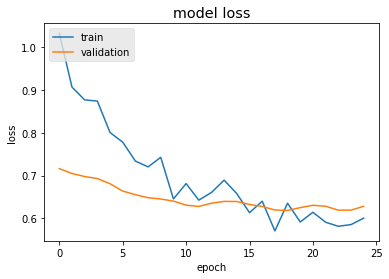

In [ ]:
# plotting losses to see if it would have benefitted from more epochs

plot_hist(hist, metric="loss")

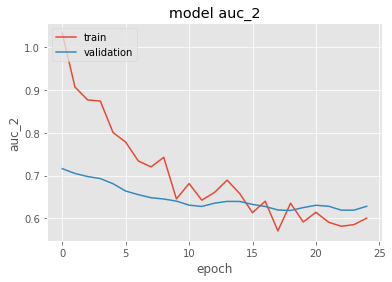

In [ ]:
plot_hist(hist, metric="auc_2")

2/2 [==============================] - 2s 551ms/step
No. of test images 46
{'M': 0, 'O': 1}


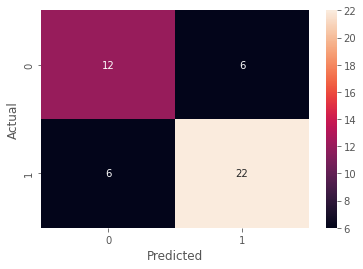

In [ ]:
# Checking the performance on testset
testGen.reset()

predIdxs = model_preprocess.predict(x=testGen, 
                                    steps=(totalTest // BATCH_SIZE) + 1
                                    )

predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)

cm = confusion_matrix(testGen.classes, predIdxs)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()


Observation: As you can see, the diagonal should have maximum number of instances.

### Fine Tuning Step

Observation: Although this step is optional, it can greatly help if your training dataset varies signficantly on which EfficientNet was trained.

We will start by unfreezing last 20 layers i.e. 1 block (plus some additional layers).

In [ ]:
def fine_tune_model(model):
    
    # unfreeze last conv block i.e. block7a which can be found in top 20 layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    # check which of these are trainable and which aren't
    for layer in model.layers:
	    print("{}: {}".format(layer, layer.trainable))
     
     
    # compile (with an even smaller learning rate)
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [ ]:
model_fine_tuned = fine_tune_model(model_preprocess)

<keras.engine.input_layer.InputLayer object at 0x7fda600afb80>: False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fda600af910>: False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fda600af970>: False
<keras.layers.core.tf_op_layer.TFOpLambda object at 0x7fda603fac40>: False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fda0c1e0490>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fda6051aee0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fda600af9a0>: False
<keras.layers.core.activation.Activation object at 0x7fda0c1fd4f0>: False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fda0c1fd880>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fda603fad90>: False
<keras.layers.core.activation.Activation object at 0x7fda0c209100>: False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D ob

In [ ]:
# training the model

# Before proceeding with training again, lets reset our train and valgen so that they start with sample #0
trainGen.reset()
valGen.reset()

es_tune = EarlyStopping(monitor='val_loss',  
                   mode='min',  
                   patience=20,  
                   verbose=1  
                   )

mc_tune = ModelCheckpoint('/content/drive/MyDrive/House Interior Prediction/fine_tuned_house.h5', 
                    monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    save_best_only=True)

hist = model_fine_tuned.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	epochs=50,
 	verbose=2,
  	callbacks=[es_tune, mc_tune]
  )

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.62959, saving model to /content/fine_tuned_house.h5
10/10 - 22s - loss: 0.5717 - auc_2: 0.8194 - val_loss: 0.6296 - val_auc_2: 0.6891 - 22s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.62959
10/10 - 13s - loss: 0.5848 - auc_2: 0.8096 - val_loss: 0.6316 - val_auc_2: 0.6857 - 13s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.62959
10/10 - 12s - loss: 0.5812 - auc_2: 0.8167 - val_loss: 0.6331 - val_auc_2: 0.6874 - 12s/epoch - 1s/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.62959
10/10 - 12s - loss: 0.5598 - auc_2: 0.8282 - val_loss: 0.6341 - val_auc_2: 0.6869 - 12s/epoch - 1s/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.62959
10/10 - 12s - loss: 0.5163 - auc_2: 0.8537 - val_loss: 0.6345 - val_auc_2: 0.6887 - 12s/epoch - 1s/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.62959
10/10 - 13s - loss: 0.5613 - auc_2: 0.8208 - val_loss: 0.6355 - val_auc_2: 0.689

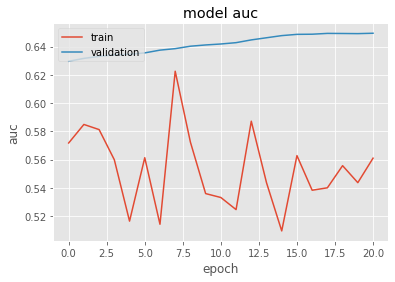

In [ ]:
plot_hist(hist, metric="auc")

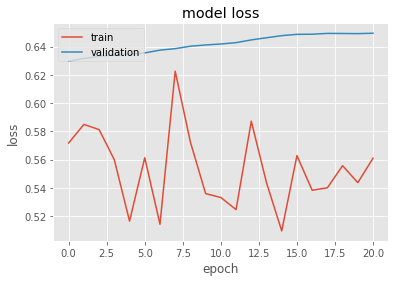

In [ ]:
plot_hist(hist, metric="loss")

Looking at the loss curve, it seems fine tuning did not add any further improvements as one would have hoped. In fact, the validation loss is quite stable. Same is true for AUC.

## Testing

In [ ]:
testGen.reset()

predIdxs = model_fine_tuned.predict(x=testGen, 
                                    steps=(totalTest // BATCH_SIZE) + 1
                                    )

predIdxs = np.argmax(predIdxs, axis = 1)
len(predIdxs)

2/2 [==============================] - 1s 68ms/step


46

In [ ]:
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           M       0.63      0.67      0.65        18
           O       0.78      0.75      0.76        28

    accuracy                           0.72        46
   macro avg       0.70      0.71      0.71        46
weighted avg       0.72      0.72      0.72        46



Observation: Model is slightly better at identifying old houses (with high recall value) compared to modern houses.

In other words, of all the actual old houses, our model predicted 82% of them.

In [ ]:
cm = confusion_matrix(testGen.classes, predIdxs)

In [ ]:
print(Counter(testY).keys()) # equals to list(set(words))
print(Counter(testY).values()) # counts the elements' frequency

dict_keys(['O', 'M'])
dict_values([28, 18])


{'M': 0, 'O': 1}


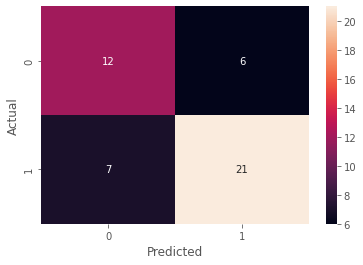

In [ ]:
print(testGen.class_indices)

heatmap = sns.heatmap(cm, annot=True)

plt.xlabel("Predicted") 
plt.ylabel("Actual")
plt.show()

We were able to correctly predict one more image from each class (How? Look at the increase in the instances on the diagonal compared to previous heat map).